## Code for training model:
This code is for trianing mask rcnn model using the detectron2 github. For this change the file paths of coco dataset. (The dataset here was creating using labelme and then labelmetococo function was used to convert it to the proper dataset.) 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [2]:
# Import Libraries:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.data import transforms as T
# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo, structures
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper

from detectron2.data.datasets import register_coco_instances

In [3]:
#register_coco_instances("my_dataset_train", {}, "./MatlabTraining/Data/train.json","")
register_coco_instances("my_dataset_train", {}, "./train.json","")

register_coco_instances("my_dataset_test", {}, "./test.json","")

In [4]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

WARNING [05/01 10:24:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/01 10:24:38 d2.data.datasets.coco]: Loaded 1384 images in COCO format from ./train.json
WARNING [05/01 10:24:38 d2.data.datasets.coco]: Filtered out 1034 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully


In [5]:
val_metadata = MetadataCatalog.get("my_dataset_test")
val_dataset_dicts = DatasetCatalog.get("my_dataset_test")

WARNING [05/01 10:24:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/01 10:24:39 d2.data.datasets.coco]: Loaded 125 images in COCO format from ./test.json
WARNING [05/01 10:24:39 d2.data.datasets.coco]: Filtered out 2 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully


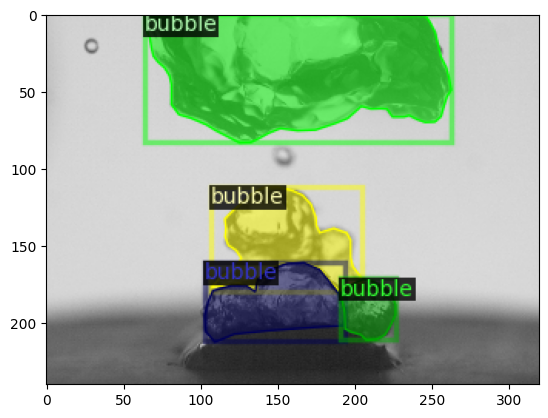

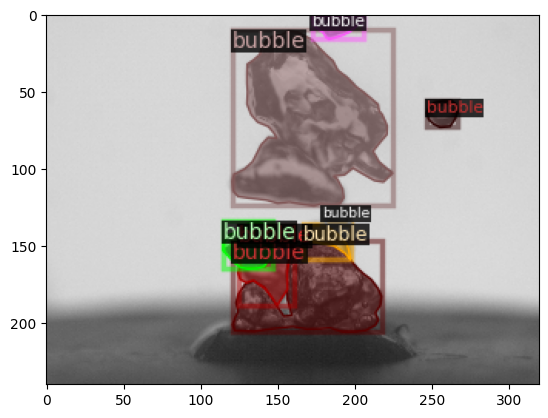

In [6]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "./Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_MATLAB1.pth")  # path to the model we just trained
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
#trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


In [8]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    mean = 0
    std_dev = 25
    gaussian_noise = np.random.normal(mean, std_dev, image.shape).astype(np.uint8)
    #noisy_image = cv2.add(image, gaussian_noise)
    
    transform_list = [
        #T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        #T.RandomRotation(angle=[90, 90]),
        #T.RandomNoise(mean=0.0, std=0.1),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [10]:
trainer=CustomTrainer(cfg)
trainer.resume_or_load(resume=False)

[05/01 10:24:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [05/01 10:24:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/01 10:24:44 d2.data.datasets.coco]: Loaded 1384 images in COCO format from ./train.json
WARNING [05/01 10:24:44 d2.data.datasets.coco]: Filtered out 1034 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully
[05/01 10:24:44 d2.data.build]: Removed 19 images with no usable annotations. 1365 images left.
[05/01 10:24:44 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   bubble   | 11750        |
|            |              |
[05/01 10:24:44 d2.data.build]: Using training sampler TrainingSampler
[05/01 10:24:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/01 10:24:44 d2.data.commo

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

from detectron2.data import DatasetMapper, build_detection_train_loader  # Import the necessary functions


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        augmentations = [T.RandomBrightness(0.9, 1.1),
                         T.RandomFlip(prob=0.5),
                         T.RandomCrop("absolute", (640, 640))]
        
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)

trainer = MyTrainer(cfg)

class MyTrainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=T.AugmentationList([T.RandomBrightness(0.9,1.1),
                                                                                     T.RandomFlip(prob=0.5), 
                                                                                     T.RandomCrop("absolute", (640,640))]))
        return build_detection_train_loader(cfg, mapper=mapper)

#trainer = DefaultTrainer(cfg) 
#trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

In [11]:
trainer.train() #Start the training process

[05/01 10:24:49 d2.engine.train_loop]: Starting training from iteration 0


/home/cldunlap/.conda/envs/detectron2_4/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/01 10:24:52 d2.utils.events]:  eta: 0:01:36  iter: 19  total_loss: 2.681  loss_cls: 0.7305  loss_box_reg: 0.633  loss_mask: 0.6985  loss_rpn_cls: 0.5215  loss_rpn_loc: 0.06858    time: 0.1018  last_time: 0.0787  data_time: 0.0183  last_data_time: 0.0023   lr: 4.9953e-06  max_mem: 1581M
[05/01 10:24:54 d2.utils.events]:  eta: 0:01:33  iter: 39  total_loss: 2.474  loss_cls: 0.6753  loss_box_reg: 0.7346  loss_mask: 0.6871  loss_rpn_cls: 0.3049  loss_rpn_loc: 0.05669    time: 0.0968  last_time: 0.0970  data_time: 0.0028  last_data_time: 0.0026   lr: 9.9902e-06  max_mem: 1585M
[05/01 10:24:56 d2.utils.events]:  eta: 0:01:30  iter: 59  total_loss: 2.292  loss_cls: 0.593  loss_box_reg: 0.7169  loss_mask: 0.6613  loss_rpn_cls: 0.2274  loss_rpn_loc: 0.07305    time: 0.0938  last_time: 0.0887  data_time: 0.0028  last_data_time: 0.0019   lr: 1.4985e-05  max_mem: 1586M
[05/01 10:24:58 d2.utils.events]:  eta: 0:01:28  iter: 79  total_loss: 2.146  loss_cls: 0.5218  loss_box_reg: 0.6405  loss_mas

[05/01 10:25:44 d2.utils.events]:  eta: 0:00:38  iter: 579  total_loss: 0.8331  loss_cls: 0.159  loss_box_reg: 0.3436  loss_mask: 0.2092  loss_rpn_cls: 0.04501  loss_rpn_loc: 0.04399    time: 0.0922  last_time: 0.1036  data_time: 0.0029  last_data_time: 0.0069   lr: 0.00014486  max_mem: 1588M
[05/01 10:25:46 d2.utils.events]:  eta: 0:00:36  iter: 599  total_loss: 0.8411  loss_cls: 0.1584  loss_box_reg: 0.327  loss_mask: 0.2281  loss_rpn_cls: 0.03923  loss_rpn_loc: 0.06499    time: 0.0921  last_time: 0.0682  data_time: 0.0026  last_data_time: 0.0026   lr: 0.00014985  max_mem: 1588M
[05/01 10:25:47 d2.utils.events]:  eta: 0:00:34  iter: 619  total_loss: 0.7173  loss_cls: 0.1257  loss_box_reg: 0.2553  loss_mask: 0.1875  loss_rpn_cls: 0.04063  loss_rpn_loc: 0.05217    time: 0.0918  last_time: 0.0882  data_time: 0.0024  last_data_time: 0.0027   lr: 0.00015485  max_mem: 1588M
[05/01 10:25:49 d2.utils.events]:  eta: 0:00:32  iter: 639  total_loss: 0.9857  loss_cls: 0.1769  loss_box_reg: 0.340

In [12]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "./Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/01 12:15:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Models/model_final.pth ...


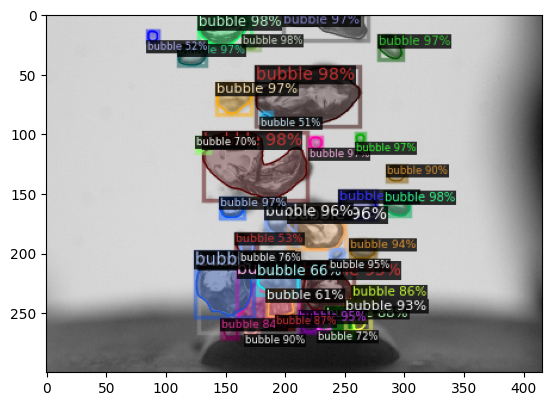

In [34]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:,:,::-1])
    #cv2.imshow(out.get_image()[:, :, ::-1])

In [39]:
outputs

{'instances': Instances(num_instances=19, image_height=600, image_width=832, fields=[pred_boxes: Boxes(tensor([[206.7013,  81.7761, 402.0662, 387.8672],
         [253.6763,   0.0000, 392.5688,  59.5069],
         [242.3540, 383.3203, 361.0851, 534.4343],
         [422.8099,  23.4645, 540.4128, 126.9222],
         [379.0716, 334.9224, 543.4264, 514.4578],
         [486.2831, 450.4977, 552.6722, 531.3524],
         [345.6780, 241.0086, 467.0625, 302.5173],
         [421.4219, 453.0798, 551.0528, 532.6010],
         [255.9249,   3.2263, 545.3460, 126.1885],
         [380.7295, 364.4647, 520.2157, 466.8485],
         [200.6166,  90.6023, 458.0528, 542.8709],
         [425.5457,  79.2370, 523.5317, 139.6455],
         [423.9966, 328.8829, 533.9449, 401.6950],
         [317.3686, 390.7069, 360.1119, 429.6377],
         [275.9396, 507.3604, 297.8947, 542.6887],
         [331.2652, 478.6964, 406.8005, 526.8787],
         [421.8302, 465.5875, 486.2144, 520.4355],
         [277.9852, 496.4168, 3

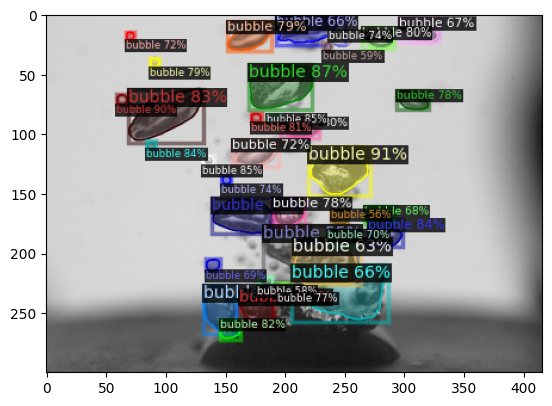

In [40]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

im = cv2.imread('/mnt/share/zdrive/Christy/Boiling-69/15W/Img000413.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=val_metadata,
               scale=0.5,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:,:,::-1])


In [41]:
outputs

{'instances': Instances(num_instances=35, image_height=600, image_width=832, fields=[pred_boxes: Boxes(tensor([[4.3989e+02, 2.2248e+02, 5.4426e+02, 3.0406e+02],
         [1.1720e+02, 1.3430e+02, 1.3580e+02, 1.5266e+02],
         [3.3967e+02, 8.3244e+01, 4.4671e+02, 1.6002e+02],
         [3.6914e+02, 1.6798e+02, 3.9459e+02, 1.9058e+02],
         [2.6192e+02, 2.3605e+02, 2.8200e+02, 2.5372e+02],
         [5.3964e+02, 3.4374e+02, 5.9800e+02, 3.8910e+02],
         [1.6889e+02, 2.1284e+02, 1.8317e+02, 2.2688e+02],
         [1.3715e+02, 1.2590e+02, 2.6382e+02, 2.1558e+02],
         [2.9120e+02, 5.1282e+02, 3.2690e+02, 5.4507e+02],
         [3.4318e+02, 1.6612e+02, 3.6112e+02, 1.8223e+02],
         [5.2919e+02, 2.1905e+01, 5.8306e+02, 5.8943e+01],
         [3.9381e+02, 1.7436e+02, 4.5793e+02, 2.0854e+02],
         [2.6401e+02, 4.5403e+02, 3.2133e+02, 5.3557e+02],
         [3.0425e+02, 1.2761e+01, 3.7789e+02, 6.1245e+01],
         [1.7380e+02, 7.3072e+01, 1.9002e+02, 8.9296e+01],
         [5.8

In [42]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator=COCOEvaluator("my_dataset_val", output_dir='./help')
val_loader=build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model,val_loader, evaluator))

FileNotFoundError: [Errno 2] No such file or directory: './val.json'

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator=COCOEvaluator("my_dataset_val", output_dir='./help')
val_loader=build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model,val_loader, evaluator))

WARNING [11/08 13:22:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/08 13:22:26 d2.data.datasets.coco]: Loaded 19 images in COCO format from ./val.json
[11/08 13:22:26 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   bubble   | 185          |
|            |              |
[11/08 13:22:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/08 13:22:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/08 13:22:26 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[11/08 13:22:26 d2.data.common]: Serialized dataset takes 0.05 MiB
[11/08 13:22:26 d2.evaluation.evaluator]: Start inference on 19 batches
[11/08 13:22:27 d2.evaluation.ev

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator=COCOEvaluator("my_dataset_val", output_dir='./help')
val_loader=build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model,val_loader, evaluator))

WARNING [11/08 13:28:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/08 13:28:26 d2.data.datasets.coco]: Loaded 19 images in COCO format from ./val.json
[11/08 13:28:26 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   bubble   | 185          |
|            |              |
[11/08 13:28:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/08 13:28:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/08 13:28:26 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[11/08 13:28:26 d2.data.common]: Serialized dataset takes 0.05 MiB
[11/08 13:28:26 d2.evaluation.evaluator]: Start inference on 19 batches
[11/08 13:28:27 d2.evaluation.ev